# Marginal Effects in BRMS

I tried to stick closely to Chris's analysis and the figures produced. Generally things look pretty similar, but I didn't analyze all variables, just $\texttt{rcsup2}$

Below I load the data, dependencies, and set the plotting style.

In [700]:
# More transformations and data recodes.....
rm(list = ls())
library(brms)
# library(tidyverse)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
#### Load cleaned data
load("/Users/Chris/Dropbox/masterData/bookData/wff1.Rdata")
ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = -.08, vjust = 0, colour = "#3C3C3C", size = 14),
  axis.text.x = element_text(size = 12, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 1, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 12, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white")
)
####
print("The data dimensions")
dim(data)

[1] "The data dimensions"


[1] 1229  170

I start by replicating Chris's analysis. The general pipeline is below. I first load the data, create a smaller version of the data with just the covariates we're analzying and then I fit the model. I then extract the posterior samples and calculate the marginal effects. I'll explain the code in more detail in a bit, but first I wanted to reproduce Chris's linear analysis.

Compiling Stan program...

Start sampling

`summarise()` has grouped output by 'cond'. You can override using the
`.groups` argument.


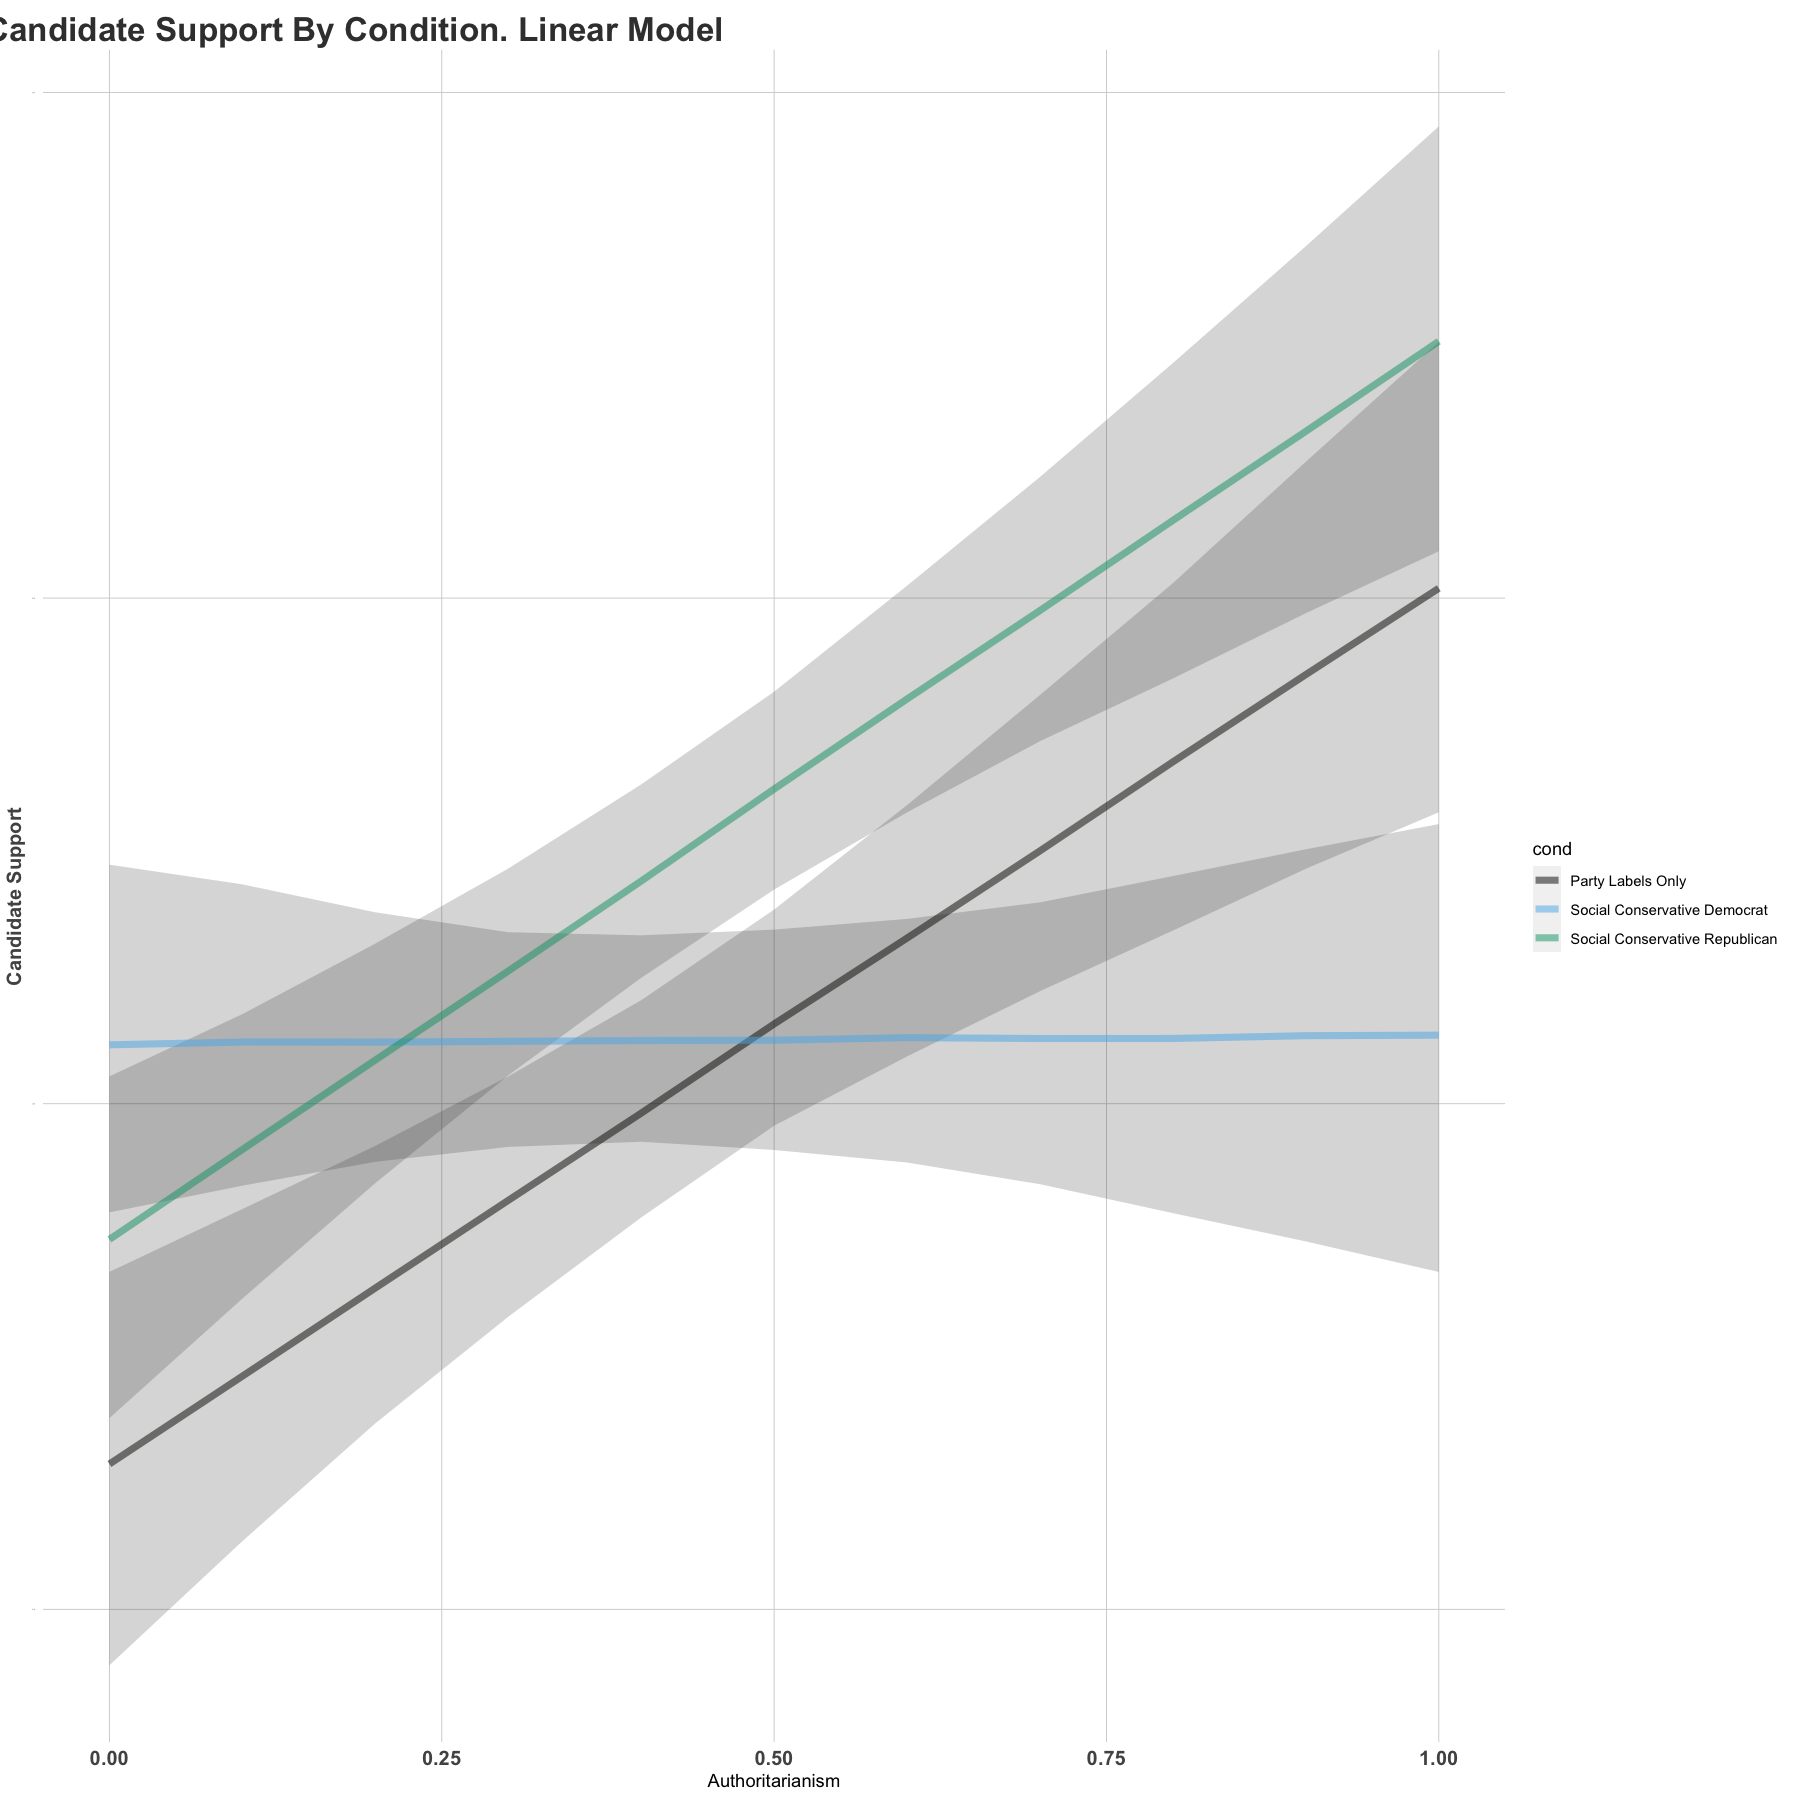

In [717]:
options(repr.plot.width = 15, repr.plot.height = 15)

## Chris's Code

###### subset to white respondents + party check passers
wdata <- subset(data, white == 1 & bc1 == 1 & sc1 == 1)

###### subset to white respondents
wdata <- subset(data, white == 1)

## Make a smaller version of the data, to omit missing values
smallData <- wdata %>%
  select(
    female, age, rinc, college, jewish, cath, other,
    cond, raut, rcsup2
  ) %>%
  mutate(female = as.numeric(female)) %>%
  na.omit()
####


#1) Estimate the Model

fitLinear <- brm(rcsup2 ~ female + age + rinc + college + jewish + cath + other + cond * raut,
  data = smallData,
  chains = 3,
  family = gaussian(link = "identity"),
  cores = 6, seed = 1234,
  iter = 1000
)

#2) Using the data, calculate the mean values of the predictors, vary authoritarianism and the condition --> Pass the data to the model to generate predictions ---> Plot the predictions
smallData %>%
  data_grid(
    age = mean(age),
    cath = mean(cath),
    rinc = mean(rinc),
    college = mean(college),
    jewish = mean(jewish),
    other = mean(other),
    # Vary authoritarianism
    raut = seq(from = 0, to = 1, by = .1),
    female = mean(female),
    cond = c("cont", "treat1", "treat2")
  ) %>%
  # Pass to the fitted model
  add_epred_draws(fitLinear) %>%
  # Group and summarize accordingly
  group_by(cond, raut) %>%
  summarize(
    mean = mean(.epred),
    median = median(.epred),
    lower = quantile(.epred, 0.025),
    upper = quantile(.epred, 0.975)
  ) %>%
    mutate(cond = recode(cond, "cont" = "Party Labels Only", "treat1" = "Social Conservative Republican", "treat2" = "Social Conservative Democrat")) %>%
    # Pass to GGPLOT
      ggplot(aes(y = median, ymax = upper, ymin = lower, x = raut, group = cond)) +
      geom_ribbon(alpha = 0.2) +
      geom_line(aes(color = cond), alpha = 0.5, linewidth = 2) +
      ggtitle("Candidate Support By Condition. Linear Model") +
      scale_y_continuous("Candidate Support") +
      scale_x_continuous("Authoritarianism") +
      ggtheme +
      scale_color_manual(values = c("#020100", "#56b3e9f3", "#009E73")) +
      theme(plot.title = element_text(size = 20))

Looks pretty close. Now, the quadratic.

In [703]:
# Fit the model in BRMS
library(brms)
# Add a squared term for teh model. Also I changed female to numeric. It wasn't reading correctly.
df = smallData %>%
  mutate(raut2 = raut^2) %>%
  mutate(female = as.numeric(female)) %>%
  na.omit()

# Estimate the model

fitQuadratic <- brm(rcsup2 ~ female + age + rinc + college + jewish + cath +
                    other + raut + raut2 + cond*raut + cond*raut2,
  data = df,
  chains = 3,
  family = gaussian(link = "identity"),
  cores = 6,
  seed = 1234,
  iter = 1000
)


Compiling Stan program...

Start sampling



Ther specification in BRMS is nearly identical to the standard R syntax. The only difference is there are a variety of parameterizations -- e.g., count models, ordinal models, etc. I tend to like this. (I get somewhat annoyed by all the different packages in R. I find it useful to use one package across models, and BRMS/Stan is pretty flexible.)

This is a linear regression with quadratic terms for authoritarianism.  I simply include the interaction with the treatment condition. I run 3 chains, 1000 iterations from the posterior each, the first 50% of the iterations are excluded as warmup, and I use 6 cores. I also use the default priors, which are non-informative. (None of this matters that much, the model is fairly simple and executes quickly -- about 2 seconds)

There are a few ways to look at the diagnostics for the model. shinystan is really good.  Bayesplot is great for static images.

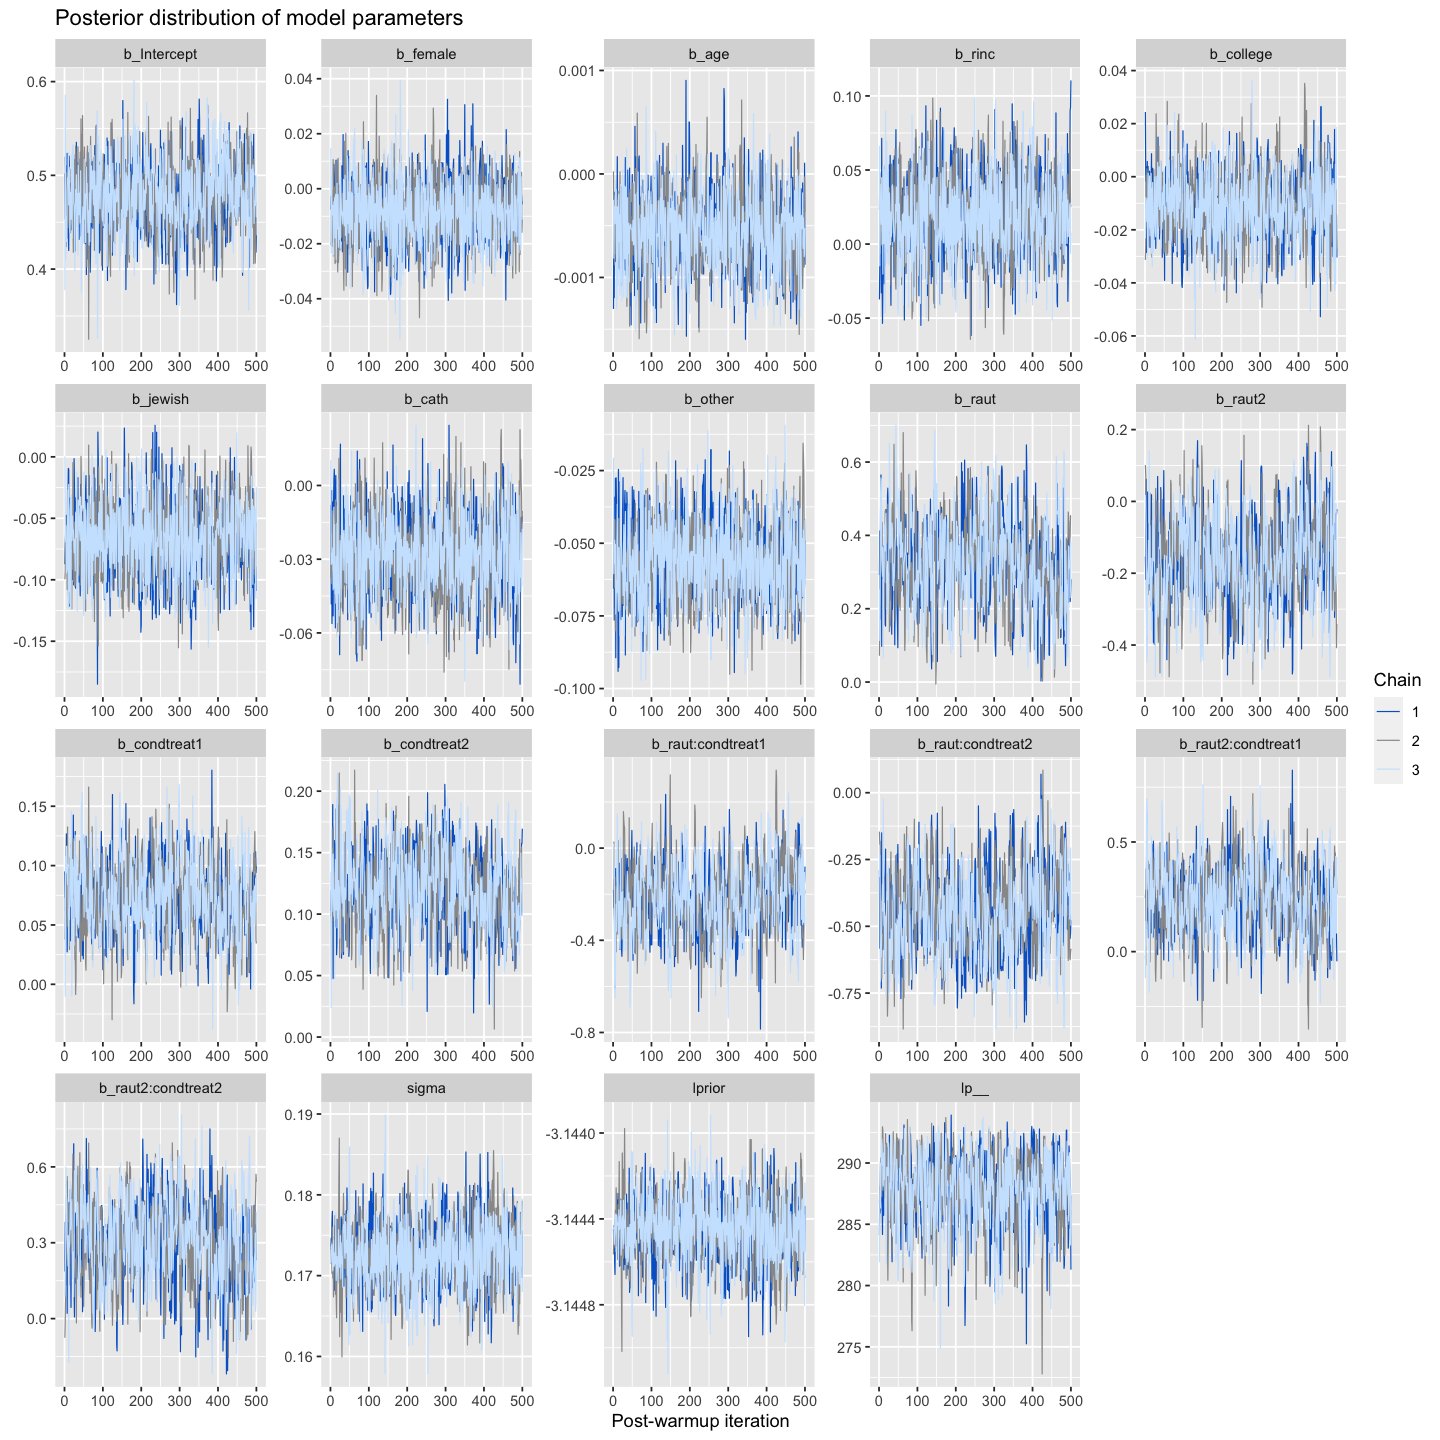

In [718]:
# Change size of plots
options(repr.plot.width = 12, repr.plot.height = 12)
library(bayesplot)
color_scheme_set("mix-brightblue-gray")
mcmc_trace(fitQuadratic) +
  xlab("Post-warmup iteration") +
  ggtitle("Posterior distribution of model parameters")

This all looks fine, so it's fine to proceed. Again, here's the basic workflow.

data $ \rightarrow $ model $ \rightarrow $ posterior $ \rightarrow $ newdata $ \rightarrow $ predict $\rightarrow $  marginal effects

To generate predictive effects, just create a dataset that has the values you want to predict over, **newdata**. Then, just like the predict method in R or stata, you can predict the values to the posterior of the model. The "uncertainty" in the model simply comes from the posterior distribution for each parameter. 

We've already loaded the **data**, specified the **model**, saved the **posteriors** after running the model.

### Create a $\texttt{newdata}$ DataFrame

In [587]:
  # Example: All varaibles at Mean, varying condition
  df %>% data_grid(
    age = mean(age),
    cath = mean(cath),
    rinc = mean(rinc),
    college = mean(college),
    jewish = mean(jewish),
    other = mean(other),
    raut = mean(raut),
    female = mean(as.numeric(female)),
    cond = c("cont", "treat1", "treat2")
  ) %>%
  mutate(raut2 = raut^2)


age,cath,rinc,college,jewish,other,raut,female,cond,raut2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0.421875,1.478009,cont,0.1779785
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0.421875,1.478009,treat1,0.1779785
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0.421875,1.478009,treat2,0.1779785


In [707]:
  # Example: All varaibles at Mean, varying condition and college
  df %>%
    data_grid(
      age = mean(age),
      cath = mean(cath),
      rinc = mean(rinc),
      college = c(0,1),
      jewish = mean(jewish),
      other = mean(other),
      raut = mean(raut),
      female = mean(as.numeric(female)),
      cond = c("cont", "treat1", "treat2")
    ) %>%
    mutate(raut2 = raut^2)


age,cath,rinc,college,jewish,other,raut,female,cond,raut2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
49.37153,0.1574074,0.2761574,0,0.04282407,0.3969907,0.421875,1.478009,cont,0.1779785
49.37153,0.1574074,0.2761574,0,0.04282407,0.3969907,0.421875,1.478009,treat1,0.1779785
49.37153,0.1574074,0.2761574,0,0.04282407,0.3969907,0.421875,1.478009,treat2,0.1779785
49.37153,0.1574074,0.2761574,1,0.04282407,0.3969907,0.421875,1.478009,cont,0.1779785
49.37153,0.1574074,0.2761574,1,0.04282407,0.3969907,0.421875,1.478009,treat1,0.1779785
49.37153,0.1574074,0.2761574,1,0.04282407,0.3969907,0.421875,1.478009,treat2,0.1779785


**Data Grid** creates a grid from the variables passed to it. There are three rows, corresponding to each condition, where all covariates are at their means. It's a wrapper for the really useful **expand.grid** function in R.

Now pass the data through the model to get posterior predictions. Pipe the data through **add_epred_draws(fitQuadratic)**, and report summary statistics.

In [720]:
  # All varaibles at Mean, predict conditions, summarize posterior
  df %>%
  # Use data to calculate means and different combinations of conditions
  data_grid(
    age = mean(age),
    cath = mean(cath),
    rinc = mean(rinc),
    college = mean(college),
    jewish = mean(jewish),
    other = mean(other),
    raut = mean(raut),
    female = mean(female),
    cond = c("cont", "treat1", "treat2")) %>%
    # The quadratic part -- needs to be added because we created a new data frame using data grid
     mutate(raut2 = raut^2)  %>%
    # Pass the data to the quadratic model
    add_epred_draws(fitQuadratic) %>%
    ## Group by experimental condition
    group_by(cond)%>%
    ## Summarize the posterior by experimental condition
    summarize(
      mean = mean(.epred),
      median = median(.epred),
      lower = quantile(.epred, 0.025),
      upper = quantile(.epred, 0.975)
    )

cond,mean,median,lower,upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
cont,0.5166753,0.5170737,0.4866933,0.5467499
treat1,0.5411972,0.5411368,0.5143328,0.5682169
treat2,0.4998451,0.4998519,0.4699928,0.5318547


# Predictive Effects for Authoritarianism

This is the general strategy for creating predictive effects. What about two variables that interact -- authoritarianism x treatments -- and/or when one takes on many values?

Here is how you would generate the predictions for authoritarianism -- simply update the code above to vary **authoritarianism** and **condition**. This will create all combinations of authoritarianism -- whatever is provided -- along the experimental conditions. We just need to square the authoritarianism variable at the end, before passing these newdata to the model. 

In [709]:
  # All varaibles at Mean, predict conditions, summarize posterior
  plotting_data = df %>%
    data_grid(
      age = mean(age),
      cath = mean(cath),
      rinc = mean(rinc),
      college = mean(college),
      jewish = mean(jewish),
      other = mean(other),
      # Vary authoritarianism, from min to max, by 0.1
      raut = seq(from = 0, to = 1, by = .1),
      female = mean(female),
      # Vary condition
      cond = c("cont", "treat1", "treat2")
    ) %>%
    mutate(raut2 = raut^2) %>%
    add_epred_draws(fitQuadratic) %>%
    group_by(cond, raut) %>%
    summarize(
      mean = mean(.epred),
      median = median(.epred),
      lower = quantile(.epred, 0.025),
      upper = quantile(.epred, 0.975)
    )
plotting_data %>% head()

`summarise()` has grouped output by 'cond'. You can override using the
`.groups` argument.


cond,raut,mean,median,lower,upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cont,0.0,0.4089702,0.4090572,0.3592902,0.4577783
cont,0.1,0.4397667,0.4395085,0.4055749,0.4735766
cont,0.2,0.4672909,0.4673612,0.4405286,0.4937253
cont,0.3,0.4915427,0.4914039,0.4627800,0.5184994
cont,0.4,0.5125222,0.5128775,0.4828753,0.5420998
cont,0.5,0.5302294,0.5301045,0.4997977,0.5611435


Now each combination of authoritarianism and condition is passed to the model. Use the same summarize and plotting code as above.

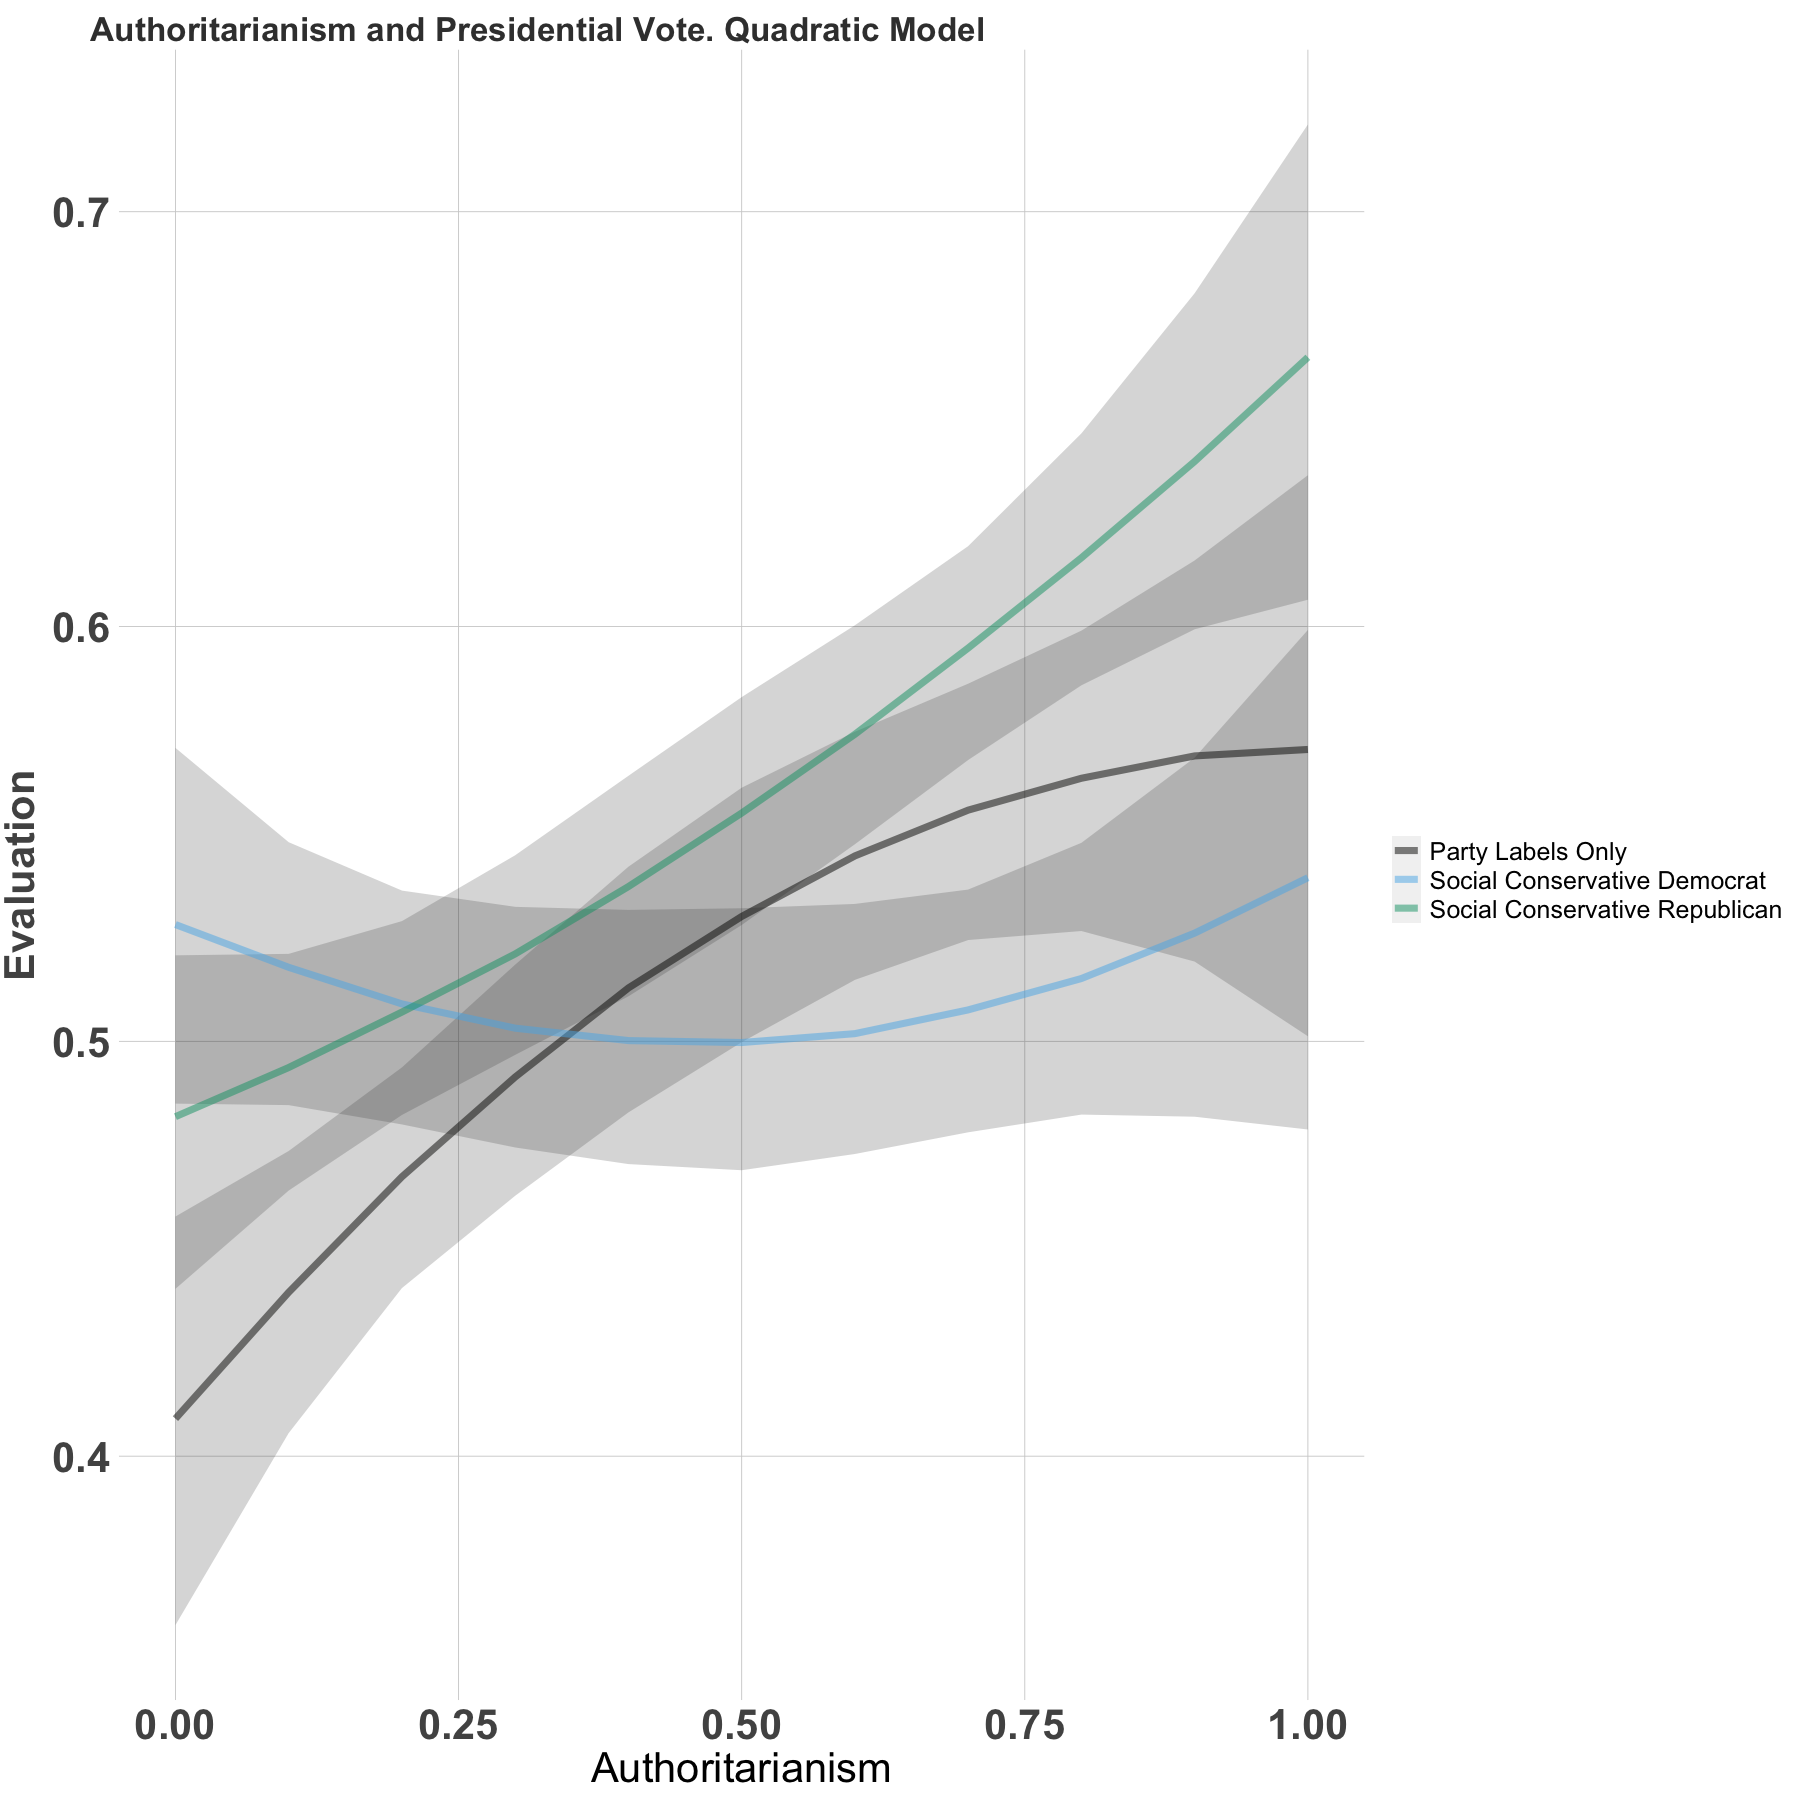

In [721]:
options(repr.plot.width = 15, repr.plot.height = 15)

plotting_data %>%
  mutate(cond = recode(cond, "cont" = "Party Labels Only", "treat1" = "Social Conservative Republican", "treat2" = "Social Conservative Democrat"))%>%
  ggplot(aes(y = median, ymax = upper, ymin = lower, x = raut, group = cond)) +
  geom_ribbon(alpha = 0.2) +
  geom_line(aes(color = cond), alpha = 0.5, linewidth = 2) +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Quadratic Model") +
  scale_y_continuous("Evaluation") +
  scale_x_continuous("Authoritarianism") +
  ggtheme +
  theme(legend.title = element_blank()) +
  scale_color_manual(values = c("#020100", "#56b3e9f3", "#009E73")) +
  theme(plot.title = element_text(size = 20)) +
  theme(legend.text = element_text(size = 15)) +
  theme(axis.text.x = element_text(size = 25))  +
  theme(legend.text = element_text(size = 15)) +
  theme(axis.text.y = element_text(size = 25))  +
  theme(axis.title.y = element_text(size = 25))  +
  theme(axis.title.x = element_text(size = 25))


To calculate the marginal effects of authoritarianism in each condition, follow the same setup. Generate predictions when authoritarianism is 1 and when authoritairanism is 0, in all the experimental conditions. Then, restructure the data and take the difference between the two conditions. This is the marginal effect of authoritarianism in each condition.

$$ y_{marginal} = (y|x_{authoritarianism} = 1, x_{condition} = i) -  (y|x_{authoritarianism} = 0, x_{condition} = i)$$

Alternatively, we could calculate the treatment effect across levels of authoritarianism. 

$$ y_{marginal} = (y|x_{authoritarianism} = i, x_{condition} = {treat}) -  (y|x_{authoritarianism} = i, x_{condition} = control)$$


In [722]:
library(tidyr)
## Construct the full data frame ###
full_dat = df %>%
  data_grid(
    age = mean(age),
    cath = mean(cath),
    rinc = mean(rinc),
    college = mean(college),
    jewish = mean(jewish),
    other = mean(other),
    # Vary authoritarianism, from min to max
    raut = seq_range(raut, 2),
    female = mean(female),
    # Vary condition
    cond = c("cont", "treat1", "treat2")
  ) %>%
  mutate(raut2 = raut^2) %>%
  add_epred_draws(fitQuadratic) %>%
  tibble() %>%
  select(.epred, raut, cond)

# We can just subset the data and calculate the differences to come up with the marginal effect

###### The marginal effect in the control condition
me  = (full_dat %>%
subset(raut == 1 & cond == "treat1", select = ".epred")) -
(full_dat %>%
  subset(raut == 1 & cond == "cont", select = ".epred")) %>% tibble()
#######

paste("The marginal effect of treatment, auth at max, when all are at mean values is", mean(me$.epred) %>% round(2))




[1] "The marginal effect of treatment, auth at max, when all are at mean values is 0.09"

## Data Structure

This is a bit of an aside, but I find it helpful to sort things out. The data structure expands when we pass it through the model. This is because there are multiple draws from the posterior. Recall the following:

1) Create a data frame with all possible permutations -- the full factorial structure -- of the variable(s) levels to pass to the function. This can be done using "data.grid." 
2) Then use this as the newdata passed to the BRMS object. 
3) Because the BRMS object doesn't include a single parameter value, but a good number of draws from the posterior of the parameter -- 3000 total, 1500 here after burn in -- the final data frame will not be as small as the newdata data frame, but rather expanded by however many draws from the posterior are saved in the BRMS object. For instance, if we hold all variables at their means, and vary authoritarianism (from min to max) and the condition variable, that gives us a dataframe of 6x10. There are 6 combinations of authoritarianism x condition (3 conditions x 2 values of authoritarianism) and 10 covariates. When we pass this through the model object, we're basically expanding the 6 rows by a factor of 1500. So, the final dataframe will be 9000x10. BRMS.predict() also adds characteristics of the predictors, so there's a few more columns.

For instance,

In [716]:
 paste("This is the size of newdata")
 df %>%
  data_grid(
    age = mean(age),
    cath = mean(cath),
    rinc = mean(rinc),
    college = mean(college),
    jewish = mean(jewish),
    other = mean(other),
    # Vary authoritarianism, from min to max, by 0.1
    raut = seq_range(raut, 2),
    female = mean(female),
    cond = c("cont", "treat1", "treat2")
  ) %>%
  mutate(raut2 = raut^2) %>%
  dim()

   paste("This is the size of data with predictions, after being passed through the model")
   df %>%
     data_grid(
       age = mean(age),
       cath = mean(cath),
       rinc = mean(rinc),
       college = mean(college),
       jewish = mean(jewish),
       other = mean(other),
       # Vary authoritarianism, from min to max, by 0.1
       raut = seq_range(raut, 2),
       female = mean(female),
       cond = c("cont", "treat1", "treat2")
     ) %>%
     mutate(raut2 = raut^2) %>%
      add_epred_draws(fitQuadratic) %>%
     dim()

[1] "This is the size of newdata"

[1]  6 10

[1] "This is the size of data with predictions, after being passed through the model"

[1] 9000   15

The six rows expand to 9000, because there are now 1500 duplicates of each row of newdata -- corresponding to the number of posterior draws from the model. The columns also expand, which include information from the model (like the iteration number). The new data includes the covariate values, plus model predictions.

We're basically working from data like this:

In [207]:
df %>%
  data_grid(
    age = mean(age),
    cath = mean(cath),
    rinc = mean(rinc),
    college = mean(college),
    jewish = mean(jewish),
    other = mean(other),
    # Vary authoritarianism, from min to max, by 0.1
    raut = seq_range(raut, 2),
    female = mean(female),
    cond = c("cont", "treat1", "treat2")
  ) %>%
  mutate(raut2 = raut^2) %>%
  add_epred_draws(fitQuadratic) %>%
  head()

age,cath,rinc,college,jewish,other,raut,female,cond,raut2,.row,.chain,.iteration,.draw,.epred
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0,1.478009,cont,0,1,NA,NA,1,0.3938479
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0,1.478009,cont,0,1,NA,NA,2,0.4033583
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0,1.478009,cont,0,1,NA,NA,3,0.4229715
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0,1.478009,cont,0,1,NA,NA,4,0.3945192
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0,1.478009,cont,0,1,NA,NA,5,0.3743614
49.37153,0.1574074,0.2761574,0.3564815,0.04282407,0.3969907,0,1.478009,cont,0,1,NA,NA,6,0.3559672


## Marginal Effect of Authoritarianism

I wrote a function to calculate the marginal effects. It does what's described above, and I just subset the data based on the moderator and levels of authoritarianism to calculate the marginal efect of authoritarianism.

In [724]:
marginal_effect <- function(modelFit = fitQuadratic, moderator = "cond", moderator_levels = c("cont", "treat1", "treat2")) {
  controls <- modelFit$data %>%
    select(-c(raut, moderator)) %>%
    summarize_if(is.numeric, mean)
  raut <- seq_range(modelFit$data$raut, 2)
  dat <- expand_grid(controls, raut = raut, {{ moderator }} := moderator_levels) %>%
    mutate(raut2 = raut^2) %>%
    add_epred_draws(modelFit)
  df <- data.frame()
  for (i in moderator_levels) {
    hi <- dat %>% filter(raut == 1 & !!sym(moderator) == i)
    lo <- dat %>% filter(raut == 0 & !!sym(moderator) == i)
    me <- hi$.epred - lo$.epred
    condition <- i
    df <- rbind(df, data.frame(me, condition))
  }
  print("The marginal effect of authoritarianism is")
  return(df)
}
marginal_effect() %>% group_by(condition) %>% summarise(
  median = median(me),
  lower = quantile(me, 0.025),
  upper = quantile(me, 0.975)
)



[1] "The marginal effect of authoritarianism is"


condition,median,lower,upper
<chr>,<dbl>,<dbl>,<dbl>
cont,0.16204638,0.08487382,0.23614365
treat1,0.18354599,0.12306637,0.24698228
treat2,0.01150694,-0.05891870,0.07869439


And plotted:

[1] "The marginal effect of authoritarianism is"


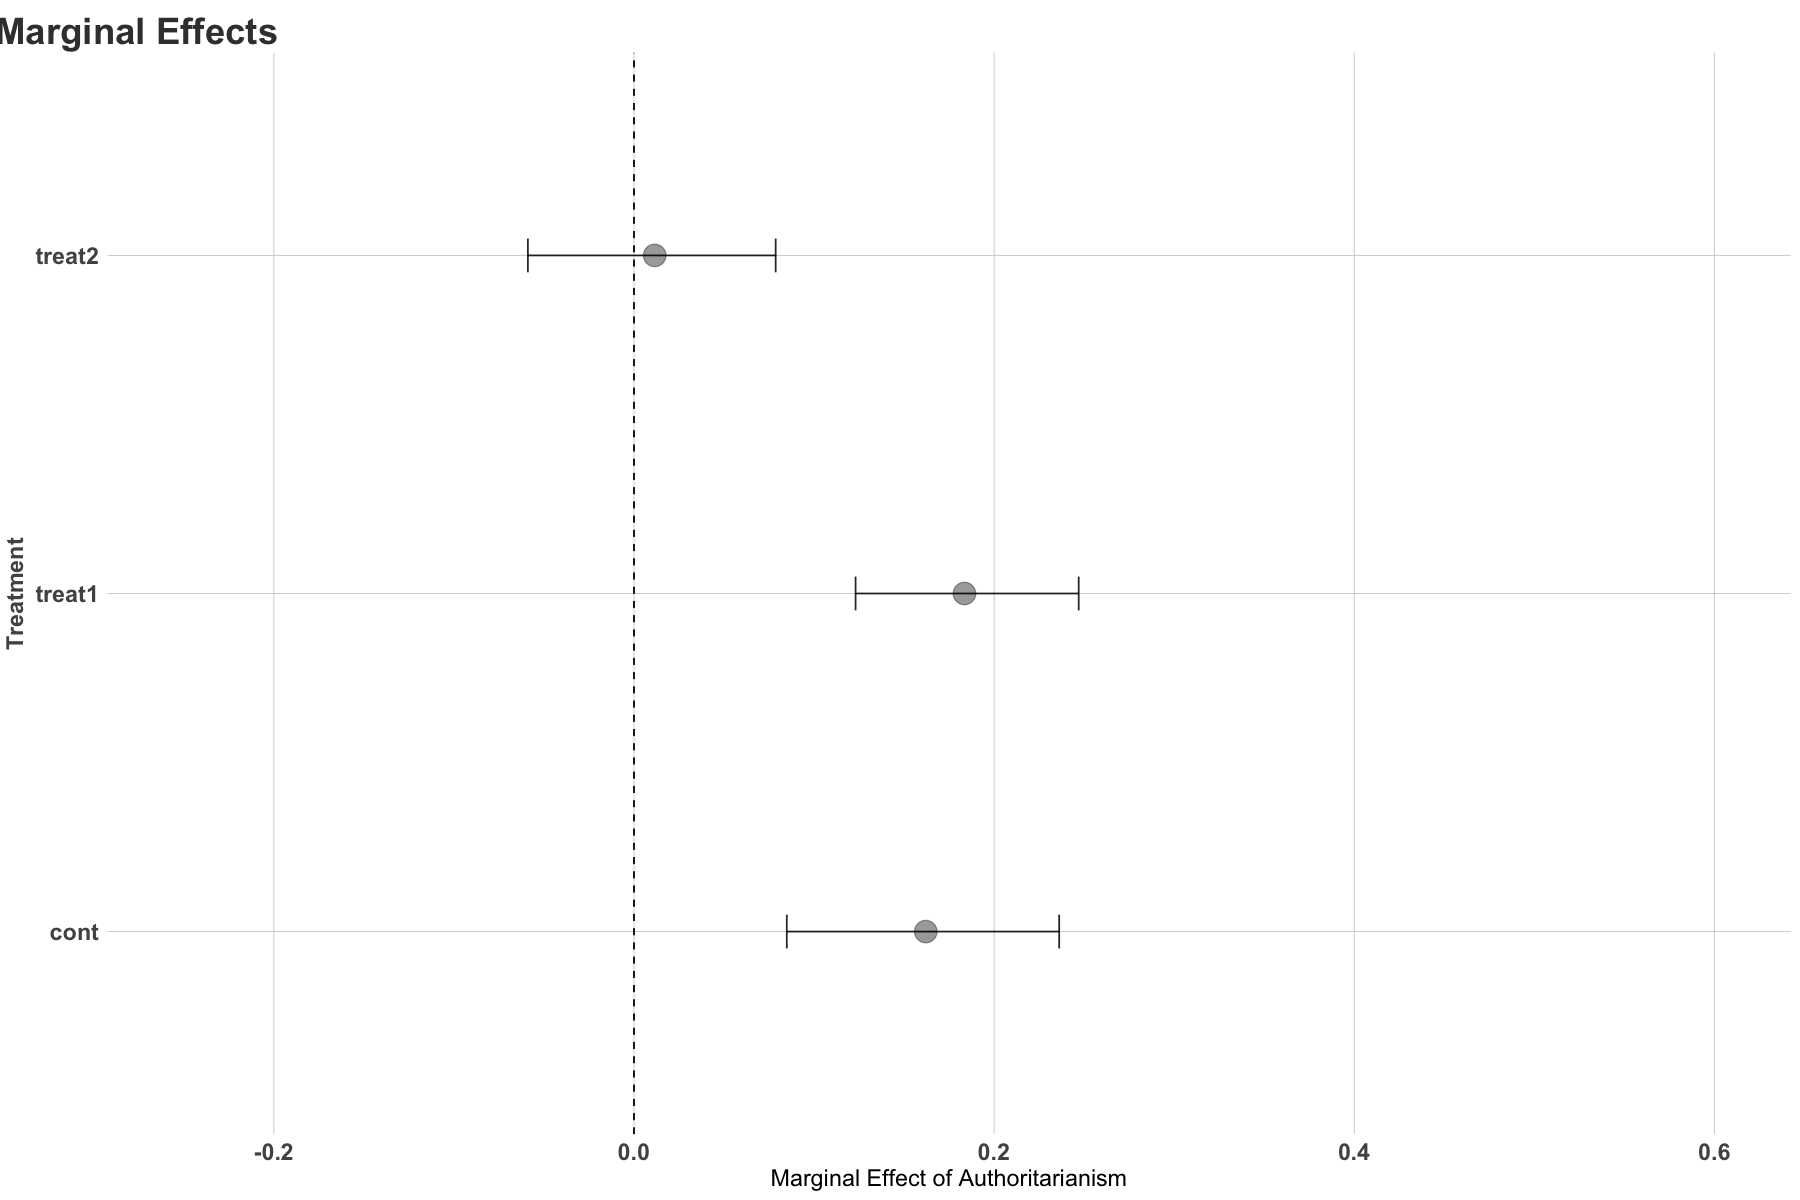

In [725]:
options(repr.plot.width = 15, repr.plot.height = 10)
marginal_effect() %>%
  group_by(condition) %>%
  summarise(
    median = median(me),
    lower = quantile(me, 0.025),
    upper = quantile(me, 0.975)
  ) %>%

ggplot(aes(
  x = condition,
  y = median, ymin = lower,
  ymax = upper)) +
  geom_point(size = 6, alpha = 0.4, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Marginal Effects") +
  ggtheme +
  scale_y_continuous("Marginal Effect of Authoritarianism", limits = c(-0.25, 0.6)) +
  scale_x_discrete("Treatment") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  coord_flip() +
    theme(plot.title = element_text(size = 22)) +
      theme(legend.text = element_text(size = 14)) +
      theme(axis.text.x = element_text(size = 14)) +
      theme(legend.text = element_text(size = 14)) +
      theme(axis.text.y = element_text(size = 14)) +
      theme(axis.title.y = element_text(size = 14)) +
      theme(axis.title.x = element_text(size = 14))


The data frame has 1500 rows. The covariates are all constant, because I set them at their means. The $.epred$ part is the linear prediction in the model. There's this package tidybayes, along with ggplot which help. We could vary authoritarianism -- from 0 to 1 -- along with the squared term and college.

# Complex Marginal Effects

This all should be enough to reproduce the experimental analysis, but I thought I'd sketch out how to adapt this to a three-way interaction. The basic idea is the same, but we need to create a data frame that has all possible combinations of the three variables. The marginal effects then just are the difference between all combinations of the two moderator variables. Say, the third variable is education

$$ Y_{marginal} = E(y|x_{authoritarianism} = 1, x_{condition} = i, x_{college} = j) -  E(y|x_{authoritarianism} = 0, x_{condition} = i, x_{college} = j)$$

## Starting with Predictive Effects

In [726]:

fitQuadratic3way <- brm(rcsup2 ~ female + age + rinc + college + jewish + cath +
                      other + raut + raut2 + cond * raut + cond * raut2 +
                      college:raut + college:raut2 + cond:college + cond:college:raut + cond:college:raut2,
                        data = df,
                        chains = 3,
                        family = gaussian(link = "identity"),
                        cores = 6,
                        seed = 1234,
                        iter = 1000
)

Compiling Stan program...

Start sampling



In [727]:
  # All varaibles at Mean, predict conditions, summarize posterior
  plotting_data <- df %>%
    data_grid(
      age = mean(age),
      cath = mean(cath),
      rinc = mean(rinc),
      #Vary education
      college = c(0, 1),
      jewish = mean(jewish),
      other = mean(other),
      # Vary authoritarianism, from min to max, by 0.1
      raut = seq(from = 0, to = 1, by = .1),
      female = mean(female),
      # Vary condition
      cond = c("cont", "treat1", "treat2")
    ) %>%
    mutate(raut2 = raut^2) %>%
    add_epred_draws(fitQuadratic3way) %>%
    group_by(cond, raut, college) %>%
    summarize(
      mean = mean(.epred),
      median = median(.epred),
      lower = quantile(.epred, 0.025),
      upper = quantile(.epred, 0.975)
    )
  plotting_data %>% head()

`summarise()` has grouped output by 'cond', 'raut'. You can override using the
`.groups` argument.


cond,raut,college,mean,median,lower,upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cont,0.0,0,0.4189872,0.4188649,0.3574143,0.4840281
cont,0.0,1,0.3928616,0.3928015,0.3156819,0.4658722
cont,0.1,0,0.4509988,0.4504470,0.4067884,0.4969105
cont,0.1,1,0.4206119,0.4200187,0.3701444,0.4747370
cont,0.2,0,0.4787375,0.4779319,0.4444791,0.5157631
cont,0.2,1,0.4470014,0.4472432,0.4022955,0.4938665


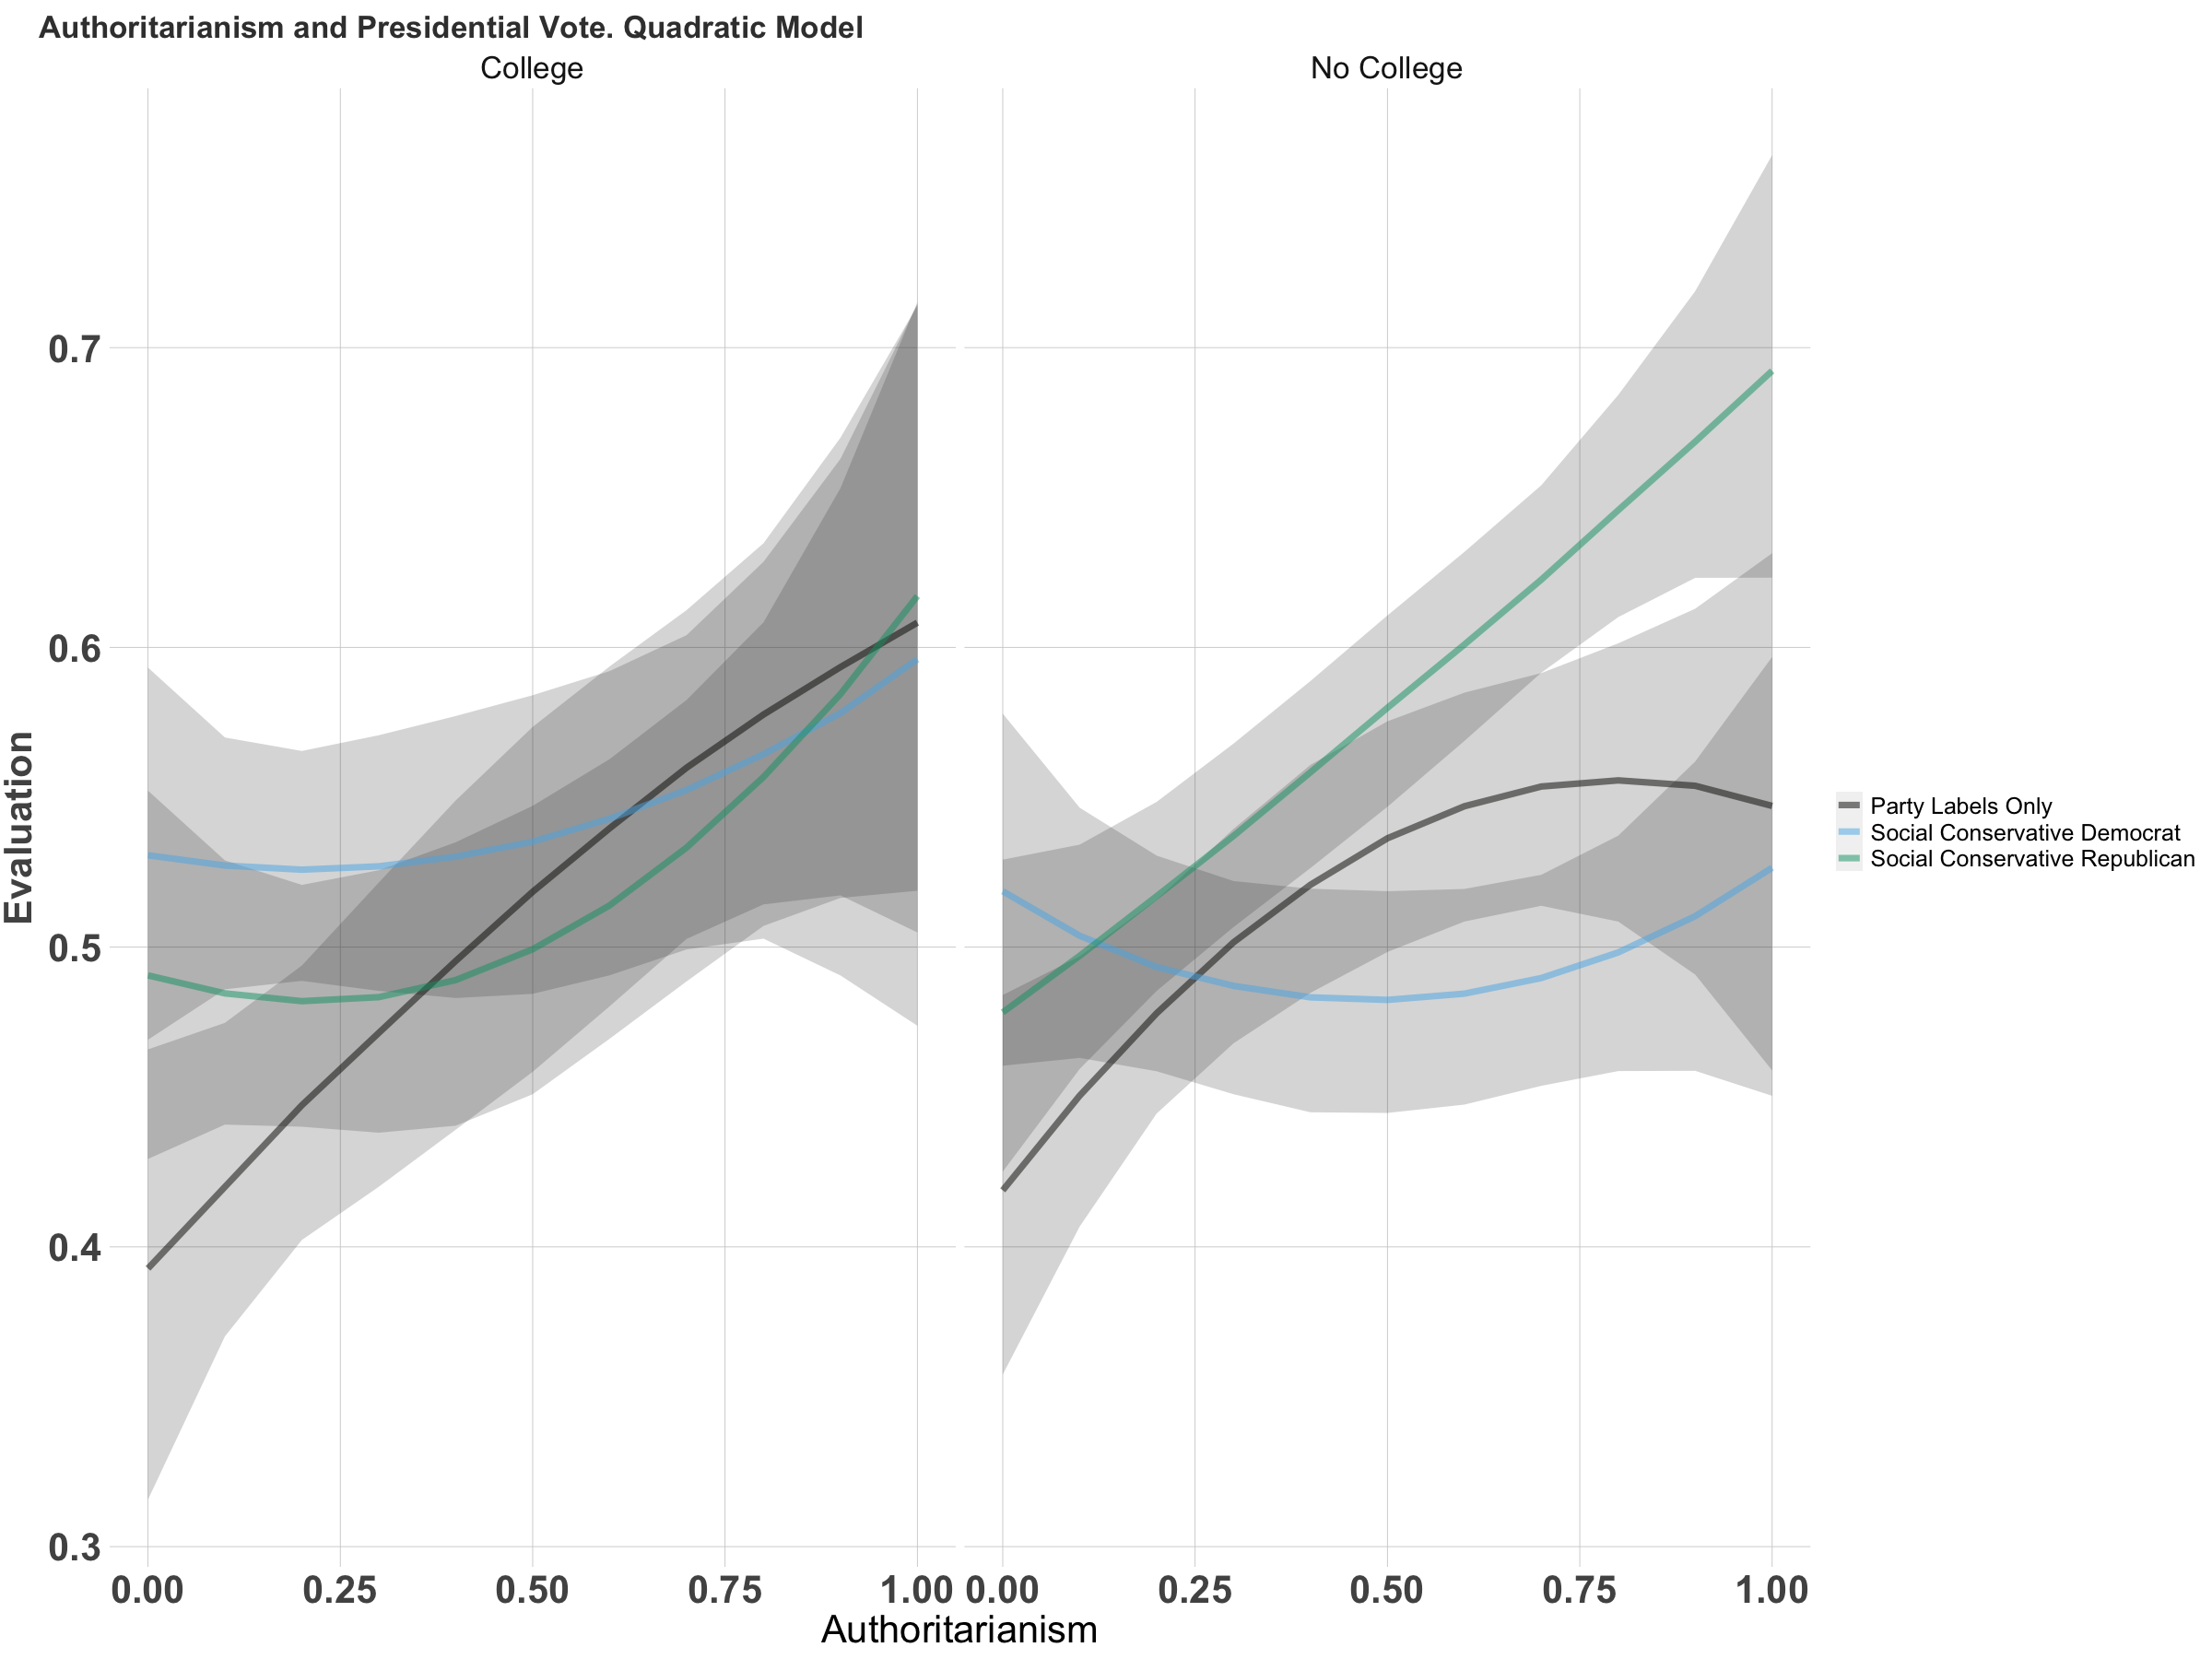

In [728]:
options(repr.plot.width = 20, repr.plot.height = 15)

plotting_data %>%
  mutate(cond = recode(cond, "cont" = "Party Labels Only", "treat1" = "Social Conservative Republican", "treat2" = "Social Conservative Democrat")) %>%
  mutate(College = ifelse(college ==1, "College", "No College"))%>%
  ggplot(aes(y = median, ymax = upper, ymin = lower, x = raut, group = cond)) +
  facet_wrap(~College) +
  geom_ribbon(alpha = 0.2) +
  geom_line(aes(color = cond), alpha = 0.5, linewidth = 2) +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Quadratic Model") +
  scale_y_continuous("Evaluation") +
  scale_x_continuous("Authoritarianism") +
  ggtheme +
  theme(legend.title = element_blank()) +
  scale_color_manual(values = c("#020100", "#56b3e9f3", "#009E73")) +
  theme(plot.title = element_text(size = 20)) +
  theme(legend.text = element_text(size = 15)) +
  theme(axis.text.x = element_text(size = 25)) +
  theme(legend.text = element_text(size = 15)) +
  theme(axis.text.y = element_text(size = 25)) +
  theme(axis.title.y = element_text(size = 25)) +
  theme(axis.title.x = element_text(size = 25)) +
  # Make facet labels to larger
  theme(strip.text = element_text(size = 20)) +
  # Change the facet labels
  theme(strip.background = element_rect(fill = "white", colour = "white", size = 1))


In [729]:
marginal_effect_three <- function(modelFit = fitQuadratic3way, moderator1 = "cond", moderator2 = "college", moderator_levels = c("cont", "treat1", "treat2")) {
  controls <- modelFit$data %>%
    select(-c(raut, moderator1, moderator2)) %>%
    summarize_if(is.numeric, mean)
  raut <- seq_range(modelFit$data$raut, 2)
  dat <- expand_grid(controls, raut = raut, {{ moderator1 }} := moderator_levels, {{ moderator2 }} := c(0, 1)) %>%
    mutate(raut2 = raut^2) %>%
    add_epred_draws(modelFit)

  df <- data.frame()
  #Loop over values of both moderators
  for (i in moderator_levels) {
    for (j in c(0, 1)){
    hi <- dat %>% filter(raut == 1 & !!sym(moderator1) == i, !!sym(moderator2) == j)
    lo <- dat %>% filter(raut == 0 & !!sym(moderator1) == i, !!sym(moderator2) == j)
    me <- hi$.epred - lo$.epred
    condition1 <- i
    condition2 <- j
    df <- rbind(df, data.frame(me, condition1, condition2))
    # df$condition1 <- {{ moderator1 }}
    }
  }
  names(df) = c("marginalEffect", {{ moderator1 }},  {{ moderator2}} )
  return(df)
}
marginal_effect_three() %>% group_by(cond, college) %>% summarise(
  median = median(marginalEffect),
  lower = quantile(marginalEffect, 0.025),
  upper = quantile(marginalEffect, 0.975)
)

`summarise()` has grouped output by 'cond'. You can override using the
`.groups` argument.


cond,college,median,lower,upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
cont,0,0.127567197,0.02959132,0.22178790
cont,1,0.217742789,0.09694798,0.33161441
treat1,0,0.216246880,0.13416519,0.29809719
treat1,1,0.126495401,0.01955068,0.22545048
treat2,0,0.009169091,-0.08243434,0.09545187
treat2,1,0.062492657,-0.06102185,0.18247699


And here is the plot

`summarise()` has grouped output by 'cond'. You can override using the
`.groups` argument.


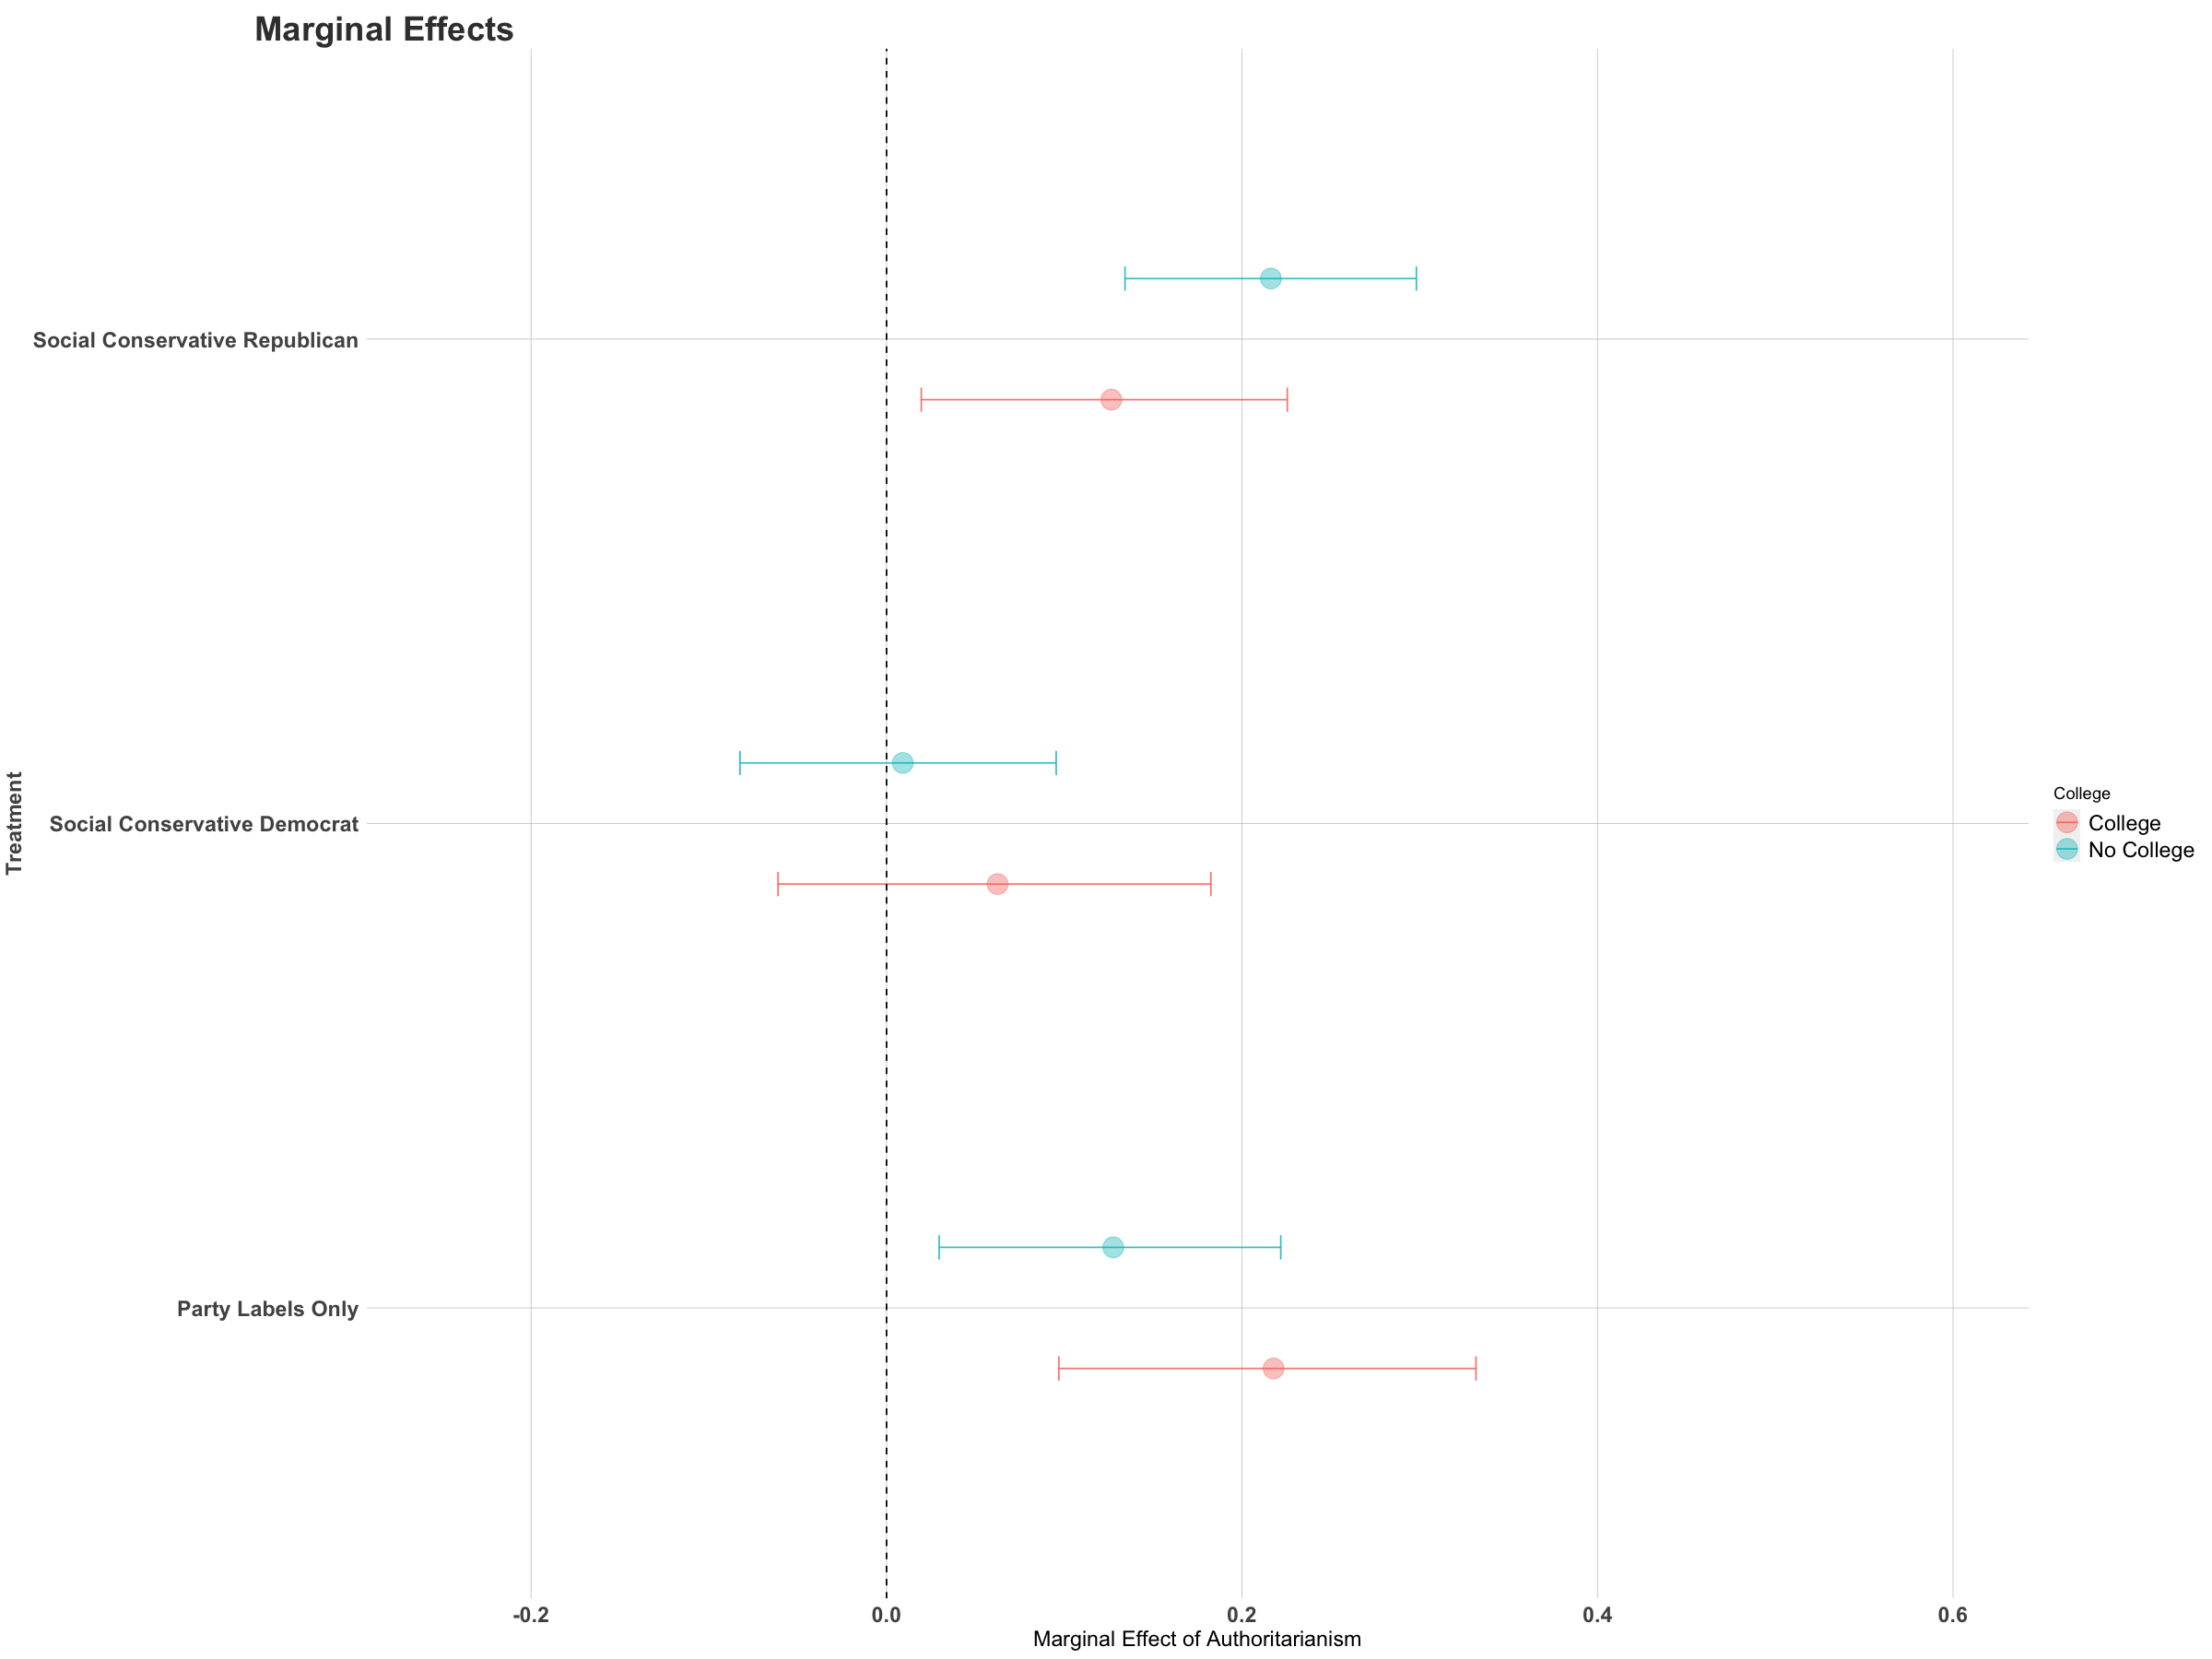

In [730]:
marginal_effect_three() %>% group_by(cond, college) %>% summarise(
  median = median(marginalEffect),
  lower = quantile(marginalEffect, 0.025),
  upper = quantile(marginalEffect, 0.975)
) %>%
  mutate(cond = recode(cond, "cont" = "Party Labels Only", "treat1" = "Social Conservative Republican", "treat2" = "Social Conservative Democrat")) %>%
  mutate(College = ifelse(college == 1, "College", "No College")) %>%
  ggplot(aes(y = median, ymax = upper, ymin = lower, x = cond, color = College)) +
 geom_point(size = 6, alpha = 0.4, position = position_dodge(width = 0.5)) +
   geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
   ggtitle("Marginal Effects") +
   ggtheme +
   scale_y_continuous("Marginal Effect of Authoritarianism", limits = c(-0.25, 0.6)) +
   scale_x_discrete("Treatment") +
   geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
   coord_flip() +
   theme(plot.title = element_text(size = 22)) +
   theme(legend.text = element_text(size = 14)) +
   theme(axis.text.x = element_text(size = 14)) +
   theme(legend.text = element_text(size = 14)) +
   theme(axis.text.y = element_text(size = 14)) +
   theme(axis.title.y = element_text(size = 14)) +
   theme(axis.title.x = element_text(size = 14))